# Competition 2: Physical Acitivity Recognition - Group 4

### **Authors**: Oguz, Bram, Alex

## Introduction

<span style="font-size:18px;"> 
    
In this project, we aim to develop a classifier for recognizing various human activities and postural transitions using data collected from smartphone sensors. We will leverage `accelerometer` and `gyroscope` data, which were obtained during controlled experiments involving **30 volunteers** aged between 19 and 48 years. These experiments encompassed a set of six fundamental activities, including three static postures **standing, sitting, lying** and three dynamic activities **walking, walking downstairs, and walking upstairs**. Additionally, we considered postural transitions such as **stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand.** To create our classifier, we will rely on a dataset randomly split into training and test sets, with 70% of the participants contributing to the training data and the remaining 30% for evaluation. Throughout this project, we will explore and implement various machine learning techniques to accurately classify these activities and transitions.
    
</span>

### Loading Packages

In [1]:
# Load the packages
library(tidyverse)
library(caret)
library(entropy)
library(dplyr)

.... = NA

# Copy all files to the working directory
system(paste0("cp -r ", list.files("../input", pattern = "recognition", full.names=TRUE), "/* ./"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




# 1. Reading the Data

## 1.1 Importing Activity Labels

In [2]:
#loading acitivity labels
act_labels = read_delim("activity_labels.txt"," ",col_names=FALSE,trim_ws=TRUE) 
act_labels = act_labels %>% select(X1,X2)
head(act_labels) 

#loading labels
labels = read_delim("./RawData/Train/labels_train.txt", " ", col_names = F)
colnames(labels) <- c('trial', 'userid', 'activity', 'start', 'end')

labels = labels %>% mutate(activity = act_labels$X2[activity])
head(labels)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 12 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (1): X2
dbl  (1): X1
lgl (11): X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2
<dbl>,<chr>
1,WALKING
2,WALKING_UPSTAIRS
3,WALKING_DOWNSTAIRS
4,SITTING
5,STANDING
6,LAYING


Rows: 849 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trial,userid,activity,start,end
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,STANDING,250,1232
1,1,STAND_TO_SIT,1233,1392
1,1,SITTING,1393,2194
1,1,SIT_TO_STAND,2195,2359
1,1,STANDING,2360,3374
1,1,STAND_TO_LIE,3375,3662


## 1.2 Merging Signals and Labels

It is much handier to have a data frame that gives an activity label for each trial, userid and each time sampleid that has matching rows for each row in the signals data frame. We can compute this from the labels data frame. First we add the sequence start:end inside a list() to each row of labels

In [3]:
# Add the sequence start:end to each row in a list.
# The result is a nested table:
sample_labels_nested = 
    labels %>% 
    rowwise() %>% # do next operation(s) rowwise
    mutate(sampleid = list(start:end)) %>%
    ungroup()

# Check the resulting table:
print(sample_labels_nested, n=10)

# A tibble: 849 × 6
   trial userid activity     start   end sampleid     
   <dbl>  <dbl> <chr>        <dbl> <dbl> <list>       
 1     1      1 STANDING       250  1232 <int [983]>  
 2     1      1 STAND_TO_SIT  1233  1392 <int [160]>  
 3     1      1 SITTING       1393  2194 <int [802]>  
 4     1      1 SIT_TO_STAND  2195  2359 <int [165]>  
 5     1      1 STANDING      2360  3374 <int [1,015]>
 6     1      1 STAND_TO_LIE  3375  3662 <int [288]>  
 7     1      1 LAYING        3663  4538 <int [876]>  
 8     1      1 LIE_TO_SIT    4539  4735 <int [197]>  
 9     1      1 SITTING       4736  5667 <int [932]>  
10     1      1 SIT_TO_LIE    5668  5859 <int [192]>  
# ℹ 839 more rows


Next we unnest the nested tibble `sample_labels_nested` to obtain a table that for each `sampleid` value stores the right `activity` label. There is however one issue: Each row corresponds to a signal segment of an activity. Some of the activities, such as WALKING, were done multiple times in the same experiment in different time segments. We need to be able to identify different segments of WALKING. Therefore, before unnesting, we'll add the row numbers as `segment` ID:


In [4]:
# Unnest the nested tabel.
sample_labels = 
    sample_labels_nested %>% 

    # Rows are segments, we need to keep track of different segements
    mutate(segment = row_number() ) %>% 

    # Expand the data frame to one sample per row
    unnest(cols = c(sampleid)) %>% 

    # Remove columns we don't need anymore
    select(-start, -end) 
# check result
tail(sample_labels)

trial,userid,activity,sampleid,segment
<dbl>,<dbl>,<chr>,<int>,<int>
61,30,WALKING_UPSTAIRS,18092,849
61,30,WALKING_UPSTAIRS,18093,849
61,30,WALKING_UPSTAIRS,18094,849
61,30,WALKING_UPSTAIRS,18095,849
61,30,WALKING_UPSTAIRS,18096,849
61,30,WALKING_UPSTAIRS,18097,849


# 2. Feature Extraction

In this section we define helper functions needed to compute **Statistical Features, Time Domain Features,** and **Frequency Domain Features.** 


When developing functions for our feature extraction methods in this project, we utilized the research paper titled "Feature Extraction from Signals" by Grasman (2018), as a primary source of guidance. You can access the paper [here](https://paper.dropbox.com/doc/Feature-extraction-from-Signals-qCp5uvj47gmyuw5nmB8lL).

## 2.1 Statistical features

In [5]:
# Mode
most_common_value <- function(x) {
    counts <- table(x, useNA = "no")
    most_frequent_idx <- which.max(counts)
    most_frequent_value <- names(counts)[most_frequent_idx]
    return(most_frequent_value)
}

# Power
power <- function(x) {
    result <- mean(x^2)
    return(result)
}

# Entropy
entropy <- function(x, nbreaks = 10) {
    r <- range(x)
    x_binned <- findInterval(x, seq(r[1], r[2], len = nbreaks))
    h <- tabulate(x_binned, nbins = nbreaks) # fast histogram
    p <- h / sum(h)
    result <- -sum(p[p > 0] * log(p[p > 0]))
    return(result)
}

# Engery
energy <- function(x) {
    sum(x^2)
}


## 2.2 Time domain features

In [6]:
# Lagged correaltion
lagged_cor <- function(x, y = x, lag = 0) {
  # compute correlation between x and a time shifted y
  r_lagged <- cor(x, dplyr::lag(y, lag), use = "pairwise")
  return(r_lagged)
}


## 2.3 Frequency domain features

In [7]:
# Spectral entropy function
sp_entropy <- function(x) {
  spec <- spectrum(x, plot = FALSE)$spec
  entropy(spec)
}

# Spectral peak function
sp_peak <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  return(spec$freq[which.max(spec$spec)])
}

# Spectral mean function
sp_mean <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  df <- spec$freq[2] - spec$freq[1]
  return(sum(spec$freq * spec$spec * df))
}

# Spectral standard deviation function
sp_sd <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  df <- spec$freq[2] - spec$freq[1]
  return(sqrt(sum((spec$freq - sp_mean(x))^2 * spec$spec * df)))
}


# 3. Putting It All Together

It's very handy to define a function that takes a data file name and carries out all the steps above. Here's such a function.

In [8]:
extract_features <- function(filename, sample_labels) {
  # extract user and experiment ID's from filename
  username <- gsub(".+user(\\d+).+", "\\1", filename) %>% as.numeric()
  expname <- gsub(".+exp(\\d+).+", "\\1", filename) %>% as.numeric()
  # import the sensor signals from the file
  user01 <- read_delim(filename, " ",
    col_names = FALSE, progress = TRUE,
    col_types = "ddd"
  )

  # merge signals with labels
  user_df <-
    data.frame(userid = username, trial = expname, user01) %>%
    mutate(sampleid = 0:(nrow(user01) - 1)) %>%
    left_join(sample_labels, by = c("userid", "trial", "sampleid"))

  # split in epochs of 128 samples and compute features per epoch
  usertimedom <- user_df %>%
    # add an epoch ID variable (on epoch = 2.56 sec)
    mutate(epoch = sampleid %/% 128) %>%
    # extract statistical features from each epoch
    group_by(epoch) %>%
    summarise(
      # keep track of user and experiment information
      user_id = username,
      exp_id = expname,

      # epoch's activity labels and start sample
      activity = most_common_value(c("-", activity)),
      sampleid = sampleid[1],

      ## 1. Statistical Features
      # mean
      level1 = mean(X1),
      level2 = mean(X2),
      level3 = mean(X3),

      # median
      median1 = median(X1),
      median2 = median(X2),
      median3 = median(X3),

      # mode
      most_common_value1 = most_common_value(X1),
      most_common_value2 = most_common_value(X2),
      most_common_value3 = most_common_value(X3),

      # variance
      var1 = var(X1),
      var2 = var(X2),
      var3 = var(X3),

      # standard deviation
      sd1 = sd(X1),
      sd2 = sd(X2),
      sd3 = sd(X3),

      # correlation
      cor1_2 = cor(X1, X2),
      cor1_3 = cor(X1, X3),
      cor2_3 = cor(X2, X3),

      # power
      pow1 = power(X1),
      pow2 = power(X2),
      pow3 = power(X3),

      # interquartile range
      iqr1 = IQR(X1),
      iqr2 = IQR(X2),
      iqr3 = IQR(X3),

      # first and third quantiles
      q1_25 = quantile(X1, .25),
      q2_25 = quantile(X2, .25),
      q3_25 = quantile(X3, .25),
      q1_75 = quantile(X1, .75),
      q2_75 = quantile(X2, .75),
      q3_75 = quantile(X3, .75),

      # skewness
      skew1 = e1071::skewness(X1),
      skew2 = e1071::skewness(X2),
      skew3 = e1071::skewness(X3),

      # kurtosis
      kurt1 = e1071::kurtosis(X1),
      kurt2 = e1071::kurtosis(X2),
      kurt3 = e1071::kurtosis(X3),

      # entropy
      entropy1 = entropy(X1),
      entropy2 = entropy(X2),
      entropy3 = entropy(X3),

      # energy
      energy1 = energy(X1),
      energy2 = energy(X2),
      energy3 = energy(X3),

      ## 2. Time Domain Features
      # lagged correlations
      ar1_1 = lagged_cor(X1, lag = 1),
      ar1_2 = lagged_cor(X1, lag = 2),
      ar2_1 = lagged_cor(X2, lag = 1),
      ar2_2 = lagged_cor(X2, lag = 2),
      ar3_1 = lagged_cor(X3, lag = 1),
      ar3_2 = lagged_cor(X3, lag = 2),
      ar12_1 = lagged_cor(X1, X2, lag = 1),
      ar12_2 = lagged_cor(X1, X2, lag = 2),
      ar13_1 = lagged_cor(X1, X3, lag = 1),
      ar13_2 = lagged_cor(X1, X3, lag = 2),
      ar23_1 = lagged_cor(X2, X3, lag = 1),
      ar23_2 = lagged_cor(X2, X3, lag = 2),

      ## 3. Frequency Domain Features
      # spectral entropy
      sp_entropy_1 = sp_entropy(X1),
      sp_entropy_2 = sp_entropy(X2),
      sp_entropy_3 = sp_entropy(X3),

      # spectral peak
      sp_peak_1 = sp_peak(X1),
      sp_peak_2 = sp_peak(X2),
      sp_peak_3 = sp_peak(X3),

      # spectral mean
      sp_mean_1 = sp_mean(X1),
      sp_mean_2 = sp_mean(X2),
      sp_mean_3 = sp_mean(X3),

      # spectral standard deviation
      sp_sd_1 = sp_sd(X1),
      sp_sd_2 = sp_sd(X2),
      sp_sd_3 = sp_sd(X3),
      n_samples = n()
    )

  usertimedom
}


# 4. Merging Training Data 

In this section we will apply extract_features() defined in the previous section on all elements in accelerometer files and gyroscope files. We will combine the resulted features in one data frame (along with 5 other variables). 

In [9]:
## 1. Accelerometer Data

# obtain a list of all files
filenames <- dir("./RawData/Train/", "^acc", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results row wise
acc_data <- map_dfr(filenames, extract_features, sample_labels)

# rename columns by assing acc_ at the beginning of each name
acc_data <- acc_data %>% rename_with(~ paste0("acc_", .x), 6:length(names(acc_data)))

## 2. Gyroscope Data

# obtain a list of all files
filenames <- dir("./RawData/Train/", "^gyro", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results row wise
gyro_data <- map_dfr(filenames, extract_features, sample_labels)

# rename columns by assing acc_ at the beginning of each name
gyro_data <- gyro_data %>% rename_with(~ paste0("gyr_", .x), 6:length(names(gyro_data)))

## 3. Merged Data (Acccelerometer + Gyroscope)
merged_df <- acc_data %>%
  left_join(gyro_data,
    by = c("user_id", "exp_id", "activity", "sampleid", "epoch")
  )

# Check the result of merging
head(merged_df)

epoch,user_id,exp_id,activity,sampleid,acc_level1,acc_level2,acc_level3,acc_median1,acc_median2,⋯,gyr_sp_peak_1,gyr_sp_peak_2,gyr_sp_peak_3,gyr_sp_mean_1,gyr_sp_mean_2,gyr_sp_mean_3,gyr_sp_sd_1,gyr_sp_sd_2,gyr_sp_sd_3,gyr_n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,1,1,-,0,0.908941,-0.1649089,0.25218100,0.862500,-0.1437500,⋯,0.0156250,0.0078125,0.0468750,1.597967e-02,3.941905e-02,1.764163e-02,0.0503112203,0.0661272999,0.0525853329,128
1,1,1,STANDING,128,1.015723,-0.1324110,0.05088976,1.020833,-0.1277778,⋯,0.0625000,0.0546875,0.0234375,1.200725e-03,2.435418e-02,3.629848e-03,0.0179655376,0.0725035465,0.0307453151,128
2,1,1,STANDING,256,1.019217,-0.1241102,0.09873047,1.019445,-0.1250000,⋯,0.0312500,0.0156250,0.0078125,3.785223e-06,2.675050e-06,3.296914e-06,0.0008474285,0.0008939049,0.0010082550,128
3,1,1,STANDING,384,1.020074,-0.1254232,0.09264323,1.020833,-0.1263889,⋯,0.0312500,0.0234375,0.0078125,5.830368e-06,4.833804e-06,4.049781e-06,0.0009059157,0.0011098283,0.0008918459,128
4,1,1,STANDING,512,1.020172,-0.1297960,0.08509115,1.019445,-0.1305556,⋯,0.0078125,0.0312500,0.0312500,5.064767e-06,4.562142e-06,3.406414e-06,0.0009504851,0.0010574223,0.0008545783,128
5,1,1,STANDING,640,1.020757,-0.1285590,0.08496094,1.020833,-0.1277778,⋯,0.0312500,0.0781250,0.0546875,4.914521e-06,3.769410e-06,4.274318e-06,0.0009253297,0.0009145764,0.0009264248,128


The resulted data frame consists of 139 columns, 134 of which are predictors.

# 5. Cleaning Training Data
We will first omit NA's to avoid errors and then clean the training data using functions from the `caret` package.

In [10]:
# first, omit NA's to avoid errors later 
merged_df <- na.omit(merged_df)

## 5.1 Highly correlated features
To start with, let's create an appropriate data frame and call it 'check_cor'. 

In [11]:
# select feature columns (all columns expect the first five)
check_cor <- merged_df[, 6:ncol(merged_df)]

# check whether a column contains character values 
char_columns <- sapply(check_cor, is.character)

# convert character columns to numeric
check_cor[char_columns] <- lapply(check_cor[char_columns], as.numeric)

Now, using this data frame we can remove highly correlated features.

In [12]:
cor_matrix <- cor(check_cor)
high_corr <- caret::findCorrelation(cor_matrix, cutoff = 0.9)
high_corr # 51 features will be removed 
check_cor <- check_cor[, -high_corr]

[1]   8   9  13  19  22  25  26  27  28  40  51  52  65  87  88  90 107 108 109
[20] 117 119 120 121 128 131 132   1   2   3   4  14  15   5   6  20  21  43  47
[39]  16  49  18  53  68  77  80  83  84  78  79 130  67

## 5.2 Highly correlated linear combinations

In [13]:
lin_combo <- caret::findLinearCombos(check_cor)
lin_combo$remove # 2 features will be removed
check_cor <- check_cor[, -lin_combo$remove]

[1] 55 57

## 5.3 Features with near-zero variation

In [14]:
zero_variance <- caret::nearZeroVar(check_cor)
zero_variance # 1 feature will be removed
check_cor <- check_cor[, -zero_variance]

[1] 81

# 6. Model fitting

Before we fit our models, let's prepare the data after the data cleaning process.

In [15]:
# add activity column back
merged_df <- cbind(merged_df[, 4], check_cor)

# 139 columns - 1:5 columns - 51 higly correlated features - 2 highly correlated linear combinations 
# - 1 near-zero variation feature + 4th column = 81 columns

ncol(merged_df)
head(merged_df)

[1] 81

,activity,acc_most_common_value1,acc_var1,acc_var2,acc_var3,acc_cor1_3,acc_iqr2,acc_iqr3,acc_q2_75,acc_q3_75,⋯,gyr_ar12_1,gyr_ar13_1,gyr_sp_entropy_1,gyr_sp_entropy_2,gyr_sp_entropy_3,gyr_sp_peak_1,gyr_sp_peak_2,gyr_sp_peak_3,gyr_sp_mean_2,gyr_sp_sd_3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-,0.8513889,2.155967e-02,6.712583e-03,1.244492e-01,-0.420072219,0.119097221,0.637500033,-0.1065972,0.55625003,⋯,0.40172273,-0.11561293,1.1917661,0.4574458,1.1473921,0.0156250,0.0078125,0.0468750,3.941905e-02,0.0525853329
2,STANDING,1.0180556,6.771014e-03,2.409512e-03,1.068274e-02,-0.135918265,0.043402774,0.084027781,-0.1152778,0.10902778,⋯,-0.06176686,0.13260638,1.1455780,0.7867863,0.5717178,0.0625000,0.0546875,0.0234375,2.435418e-02,0.0307453151
3,STANDING,1.0194445,6.433431e-06,1.521138e-05,3.147260e-05,-0.004478246,0.005555555,0.005555555,-0.1208333,0.10138889,⋯,0.01317126,-0.14471552,0.5147188,1.6490536,1.0916376,0.0312500,0.0156250,0.0078125,2.675050e-06,0.0010082550
4,STANDING,1.0194445,1.084077e-05,4.886504e-05,5.690920e-05,-0.064075880,0.010069442,0.009722225,-0.1204861,0.09722223,⋯,-0.09806813,-0.05906356,0.7588593,1.0927530,0.7281952,0.0312500,0.0234375,0.0078125,4.833804e-06,0.0008918459
5,STANDING,1.0194445,8.109932e-06,2.402485e-05,2.884358e-05,-0.076268087,0.005555555,0.005555555,-0.1277778,0.08750000,⋯,-0.35076721,0.57796574,0.6202620,0.6067769,0.4276092,0.0078125,0.0312500,0.0312500,4.562142e-06,0.0008545783
6,STANDING,1.0222223,7.998862e-06,6.232838e-05,5.468400e-05,-0.220633409,0.006944447,0.008333333,-0.1236111,0.08888889,⋯,-0.05752755,0.48180132,0.6120862,0.8216832,0.7281952,0.0312500,0.0781250,0.0546875,3.769410e-06,0.0009264248


Now we are going to use five models discussed in Chapter 4 of 'An Introduction to Statistical Learning' book: **linear discriminant analysis, quadratic discriminant analysis, k-nearest neighbours, k-nearest neighbours with standardized features and Naive Bayes method.**

In the code printed under we check to see if there is an imbalance in the data. This is a potential issue for the <span style="color:crimson;"> QDA </span> (Bejaoui et al., 2021).

In [16]:
# Count the occurrences of each character in the "activity" column
activity_counts <- table(merged_df$activity)

# Convert the result to a data frame (optional)
activity_counts_df <- as.data.frame(activity_counts)

# Print the counts
print(activity_counts_df)

                 Var1 Freq
1                   - 1351
2              LAYING  775
3          LIE_TO_SIT   60
4        LIE_TO_STAND   78
5          SIT_TO_LIE   68
6        SIT_TO_STAND   45
7             SITTING  708
8        STAND_TO_LIE   76
9        STAND_TO_SIT   53
10           STANDING  800
11            WALKING  773
12 WALKING_DOWNSTAIRS  715
13   WALKING_UPSTAIRS  749


The data is imbalanced (which is not surprising) but this will produce an error for QDA. The code that now follows is used to manually oversample the underrepresented data.

In [17]:
# Find the counts of each class
class_counts <- table(merged_df$activity)

# Sort class counts in descending order and keep the top 5
sorted_counts_top <- sort(class_counts, decreasing = TRUE)[1:5]
sorted_counts_bottom <- sort(class_counts, increasing = TRUE)[1:5]

# Calculate the mean of the top 5 largest classes
mean_top5 <- mean(sorted_counts_top)
mean_bottom5 <- mean(sorted_counts_bottom)

# Calculate the class imbalance ratio
imbalance_ratio <- round(mean_top5 / mean_bottom5, digits = 0)
print(imbalance_ratio)

merged_df_balance <- merged_df

# Count the occurrences of each unique value in the 'activity' column
activity_counts <- merged_df_balance %>%
  group_by(activity) %>%
  summarise(count = n())

# Identify labels that occur less than 100 times
labels_to_copy <- activity_counts %>%
  filter(count < 100) %>%
  pull(activity)

# Create a new DataFrame to store the copied rows
copied_df <- data.frame()

# Loop through the labels to be copied
for (label in labels_to_copy) {
  # Filter rows with the current label
  label_rows <- merged_df_balance %>%
    filter(activity == label)
  
  # Copy the rows 15 times and append them to the new DataFrame
  for (i in 1:imbalance_ratio) {
    copied_df <- bind_rows(copied_df, label_rows)
  }
}

# Combine the copied_df with the original DataFrame
merged_df_balance <- bind_rows(merged_df_balance, copied_df)

[1] 15


In [18]:
# Count the occurrences of each character in the "activity" column
activity_counts <- table(merged_df_balance$activity)

# Convert the result to a data frame (optional)
activity_counts_df <- as.data.frame(activity_counts)

# Print the counts
print(activity_counts_df)

                 Var1 Freq
1                   - 1351
2              LAYING  775
3          LIE_TO_SIT  960
4        LIE_TO_STAND 1248
5          SIT_TO_LIE 1088
6        SIT_TO_STAND  720
7             SITTING  708
8        STAND_TO_LIE 1216
9        STAND_TO_SIT  848
10           STANDING  800
11            WALKING  773
12 WALKING_DOWNSTAIRS  715
13   WALKING_UPSTAIRS  749


In [19]:
# quadratic discriminant analysis
#fit_qda = caret::train(activity ~ .,
                      # data = merged_df_balance, method = "qda", trControl = trcntr)
#fit_qda

<div class="alert alert-block alert-info"> 📌 The QDA still produces a lot of errors so we've decided to not include it in our model comparison. </div>

***

Now we are going to use four other models discussed in Chapter 4 of 'An Introduction to Statistical Learning' book: linear discriminant analysis, k-nearest neighbours, k-nearest neighbours with standardized features, and naive Bayes classifier. 

In [20]:
# defining 10 fold cross-validation for all of the models
trcntr = trainControl('cv', number = 10, p = 0.8)

# linear discriminant analysis
fit_lda = caret::train(activity ~ .,
                       data = merged_df, method = "lda", trControl = trcntr)
fit_lda

# k-nearest neighbours
fit_knn <- caret::train(activity ~ .,
                        data = merged_df, method = "knn", trControl = trcntr)
fit_knn

# k-nearest neighbours with standardized features
fit_knns <- caret::train(activity ~ .,
                         data = merged_df, method = "knn", trControl = trcntr, preProcess = "scale")
fit_knns

#naiveBayes 
naive <- e1071::naiveBayes(activity ~ ., data = merged_df)
predictions <- predict(naive, merged_df)
correct_predictions <- sum(predictions == merged_df$activity)
naive_acc <- correct_predictions / nrow(merged_df)

Linear Discriminant Analysis 

6251 samples
  80 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5625, 5626, 5628, 5626, 5624, 5624, ... 
Resampling results:

  Accuracy   Kappa    
  0.7950725  0.7640373


k-Nearest Neighbors 

6251 samples
  80 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5625, 5626, 5627, 5625, 5628, 5627, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.6829337  0.6334243
  7  0.6781478  0.6276486
  9  0.6706288  0.6188826

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

k-Nearest Neighbors 

6251 samples
  80 predictor
  13 classes: '-', 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

Pre-processing: scaled (80) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5625, 5626, 5628, 5627, 5626, 5626, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.8061182  0.7762365
  7  0.8056354  0.7755666
  9  0.8042003  0.7738885

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

## 6.1 Model Comparison

<span style=" font-size:16px;"> We can create a barplot which would allow to compare the cross-validated accuraces of our models. As we can see on the barplot <span style="color:crimson;">  k-nearest neighbours with standardized features </span>   <span/> performed the best. Therefore, we will use that model in our prediction.

    

    


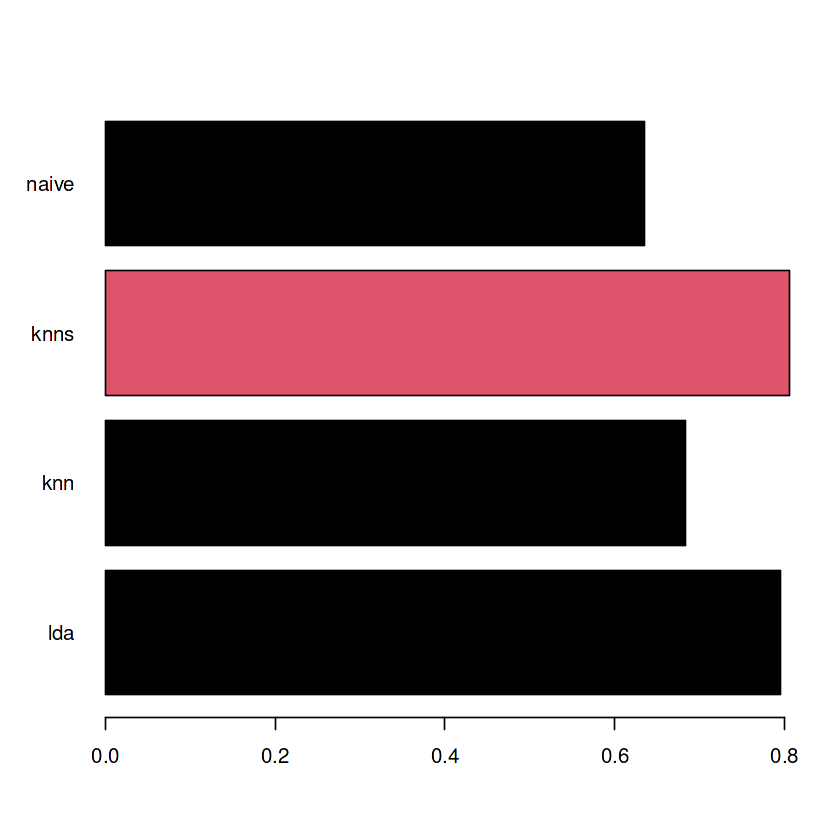

In [21]:
# put all fitted models in a named list
models <- list(lda = fit_lda, knn = fit_knn, knns = fit_knns)

# extract the cross-validated accuracies from each model
Acc <- sapply(models, function(mdl) max(mdl$results$Accuracy))
# Add the Naive Bayes accuracy to the Acc vector
Acc["naive"] <- naive_acc
              
# make a barplot with only the best performing model in red
color <- 1 + (Acc >= max(Acc))
barplot(Acc, horiz = TRUE, las = 1, col = color)


# 7. Submissions

## 7.1 Merging test data

Similarly to section 4, here we will apply extract_features() on all elements in accelerometer files and gyroscope files. However this time the files contain test data instead of training data. 

In [22]:

## 1. Accelerometer Data
# obtain a list of all files
filenames_test <- dir("./RawData/Test/", "^acc", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results row wise
acc_data_test <- map_dfr(filenames_test, extract_features, sample_labels)

# rename columns by assing acc_ at the beginning of each name
acc_data_test <- acc_data_test %>% rename_with(~ paste0("acc_", .x), 6:length(names(acc_data_test)))

## 2. Gyroscope Data
# obtain a list of all files
filenames_test <- dir("./RawData/Test/", "^gyro", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results row wise
gyro_data_test <- map_dfr(filenames_test, extract_features, sample_labels)

# rename columns by assing acc_ at the beginning of each name
gyro_data_test <- gyro_data_test %>% rename_with(~ paste0("gyr_", .x), 6:length(names(gyro_data_test)))

## 3. Merged Data (Acccelerometer + Gyroscope)
merged_df_test <- acc_data_test %>%
  left_join(gyro_data_test,
    by = c("user_id", "exp_id", "activity", "sampleid", "epoch")
  )

# Check the result of merging
head(merged_df_test)


Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `ar2_2 = lagged_cor(X2, lag = 2)`.
ℹ In group 139: `epoch = 138`.
Caused by warning in `cor()`:
! the standard deviation is zero
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


epoch,user_id,exp_id,activity,sampleid,acc_level1,acc_level2,acc_level3,acc_median1,acc_median2,⋯,gyr_sp_peak_1,gyr_sp_peak_2,gyr_sp_peak_3,gyr_sp_mean_1,gyr_sp_mean_2,gyr_sp_mean_3,gyr_sp_sd_1,gyr_sp_sd_2,gyr_sp_sd_3,gyr_n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2,3,-,0,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,⋯,0.0390625,0.0078125,0.0078125,6.649702e-02,8.405664e-02,1.299314e-02,0.0673519692,0.0865161591,0.0385035775,128
1,2,3,-,128,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,⋯,0.0703125,0.0859375,0.0156250,2.112746e-02,4.620913e-02,2.985326e-02,0.0648998986,0.0811762584,0.0594614725,128
2,2,3,-,256,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,⋯,0.0625000,0.0234375,0.0312500,7.125756e-04,1.885431e-03,4.497974e-04,0.0140940530,0.0216827923,0.0092996180,128
3,2,3,-,384,0.9928928,-0.2702691,0.1391276,0.9930556,-0.26944447,⋯,0.0078125,0.0156250,0.0078125,1.936236e-05,1.576628e-05,1.157673e-05,0.0012334046,0.0014579923,0.0013317163,128
4,2,3,-,512,0.9908854,-0.2861979,0.1286350,0.9909722,-0.28611112,⋯,0.0078125,0.0312500,0.0390625,8.137027e-06,7.494763e-06,6.702299e-06,0.0009158878,0.0009492719,0.0009459367,128
5,2,3,-,640,0.9909180,-0.2904948,0.1215712,0.9902778,-0.28888890,⋯,0.0312500,0.0468750,0.0468750,6.573663e-06,1.111430e-05,1.244990e-05,0.0010116155,0.0011919468,0.0012965526,128


## 7.2 Preparing data for making predictions

In [23]:
# remove columns that are not an activity column or a feature column
pred_df <- merged_df_test[, -c(1:3, 5, ncol(merged_df_test))]

# check whether a column contains character values
char_columns_test <- sapply(pred_df, is.character)

# convert character columns to numeric
pred_df[char_columns_test] <- lapply(pred_df[char_columns_test], as.numeric)

# replace any missing values in all columns of the pred_df data frame with the value 1
pred_df <- pred_df %>% mutate(across(everything(), ~ replace_na(.x, 1)))

Warning message in lapply(pred_df[char_columns_test], as.numeric):
“NAs introduced by coercion”


## 7.3 Making predictions

In [24]:
predictions <- predict(object = fit_knns, newdata = pred_df)

# put the predictions into pred_df
pred_df["activity"] <- predictions

# check the result
head(pred_df)

# adding user_id, exp_id, sampleid back
pred_df <- cbind(merged_df_test[, c(2:3, 5)], pred_df)

# check the result
colnames(pred_df)

activity,acc_level1,acc_level2,acc_level3,acc_median1,acc_median2,acc_median3,acc_most_common_value1,acc_most_common_value2,acc_most_common_value3,⋯,gyr_sp_entropy_3,gyr_sp_peak_1,gyr_sp_peak_2,gyr_sp_peak_3,gyr_sp_mean_1,gyr_sp_mean_2,gyr_sp_mean_3,gyr_sp_sd_1,gyr_sp_sd_2,gyr_sp_sd_3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,0.9027778,0.4527778,-0.0250000,0.8902778,⋯,0.3533693,0.0390625,0.0078125,0.0078125,6.649702e-02,8.405664e-02,1.299314e-02,0.0673519692,0.0865161591,0.0385035775
WALKING_UPSTAIRS,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,-0.2451389,0.9500000,-0.3347222,-0.4236111,⋯,0.6252003,0.0703125,0.0859375,0.0156250,2.112746e-02,4.620913e-02,2.985326e-02,0.0648998986,0.0811762584,0.0594614725
STANDING,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,0.1222222,0.9888889,-0.2694445,0.1208333,⋯,1.3466590,0.0625000,0.0234375,0.0312500,7.125756e-04,1.885431e-03,4.497974e-04,0.0140940530,0.0216827923,0.0092996180
SITTING,0.9928928,-0.2702691,0.1391276,0.9930556,-0.26944447,0.1375000,0.9930556,-0.2652778,0.1375000,⋯,0.6035395,0.0078125,0.0156250,0.0078125,1.936236e-05,1.576628e-05,1.157673e-05,0.0012334046,0.0014579923,0.0013317163
STANDING,0.9908854,-0.2861979,0.1286350,0.9909722,-0.28611112,0.1291667,0.9888889,-0.2888889,0.1277778,⋯,0.6550369,0.0078125,0.0312500,0.0390625,8.137027e-06,7.494763e-06,6.702299e-06,0.0009158878,0.0009492719,0.0009459367
STANDING,0.9909180,-0.2904948,0.1215712,0.9902778,-0.28888890,0.1208333,0.9888889,-0.2888889,0.1138889,⋯,0.3782424,0.0312500,0.0468750,0.0468750,6.573663e-06,1.111430e-05,1.244990e-05,0.0010116155,0.0011919468,0.0012965526


[1] "user_id"                "exp_id"                 "sampleid"              
  [4] "activity"               "acc_level1"             "acc_level2"            
  [7] "acc_level3"             "acc_median1"            "acc_median2"           
 [10] "acc_median3"            "acc_most_common_value1" "acc_most_common_value2"
 [13] "acc_most_common_value3" "acc_var1"               "acc_var2"              
 [16] "acc_var3"               "acc_sd1"                "acc_sd2"               
 [19] "acc_sd3"                "acc_cor1_2"             "acc_cor1_3"            
 [22] "acc_cor2_3"             "acc_pow1"               "acc_pow2"              
 [25] "acc_pow3"               "acc_iqr1"               "acc_iqr2"              
 [28] "acc_iqr3"               "acc_q1_25"              "acc_q2_25"             
 [31] "acc_q3_25"              "acc_q1_75"              "acc_q2_75"             
 [34] "acc_q3_75"              "acc_skew1"              "acc_skew2"             
 [37] "acc_skew3"              "acc_kurt1"              "acc_kurt2"             
 [40] "acc_kurt3"              "acc_entropy1"           "acc_entropy2"          
 [43] "acc_entropy3"           "acc_energy1"            "acc_energy2"           
 [46] "acc_energy3"            "acc_ar1_1"              "acc_ar1_2"             
 [49] "acc_ar2_1"              "acc_ar2_2"              "acc_ar3_1"             
 [52] "acc_ar3_2"              "acc_ar12_1"             "acc_ar12_2"            
 [55] "acc_ar13_1"             "acc_ar13_2"             "acc_ar23_1"            
 [58] "acc_ar23_2"             "acc_sp_entropy_1"       "acc_sp_entropy_2"      
 [61] "acc_sp_entropy_3"       "acc_sp_peak_1"          "acc_sp_peak_2"         
 [64] "acc_sp_peak_3"          "acc_sp_mean_1"          "acc_sp_mean_2"         
 [67] "acc_sp_mean_3"          "acc_sp_sd_1"            "acc_sp_sd_2"           
 [70] "acc_sp_sd_3"            "acc_n_samples"          "gyr_level1"            
 [73] "gyr_level2"             "gyr_level3"             "gyr_median1"           
 [76] "gyr_median2"            "gyr_median3"            "gyr_most_common_value1"
 [79] "gyr_most_common_value2" "gyr_most_common_value3" "gyr_var1"              
 [82] "gyr_var2"               "gyr_var3"               "gyr_sd1"               
 [85] "gyr_sd2"                "gyr_sd3"                "gyr_cor1_2"            
 [88] "gyr_cor1_3"             "gyr_cor2_3"             "gyr_pow1"              
 [91] "gyr_pow2"               "gyr_pow3"               "gyr_iqr1"              
 [94] "gyr_iqr2"               "gyr_iqr3"               "gyr_q1_25"             
 [97] "gyr_q2_25"              "gyr_q3_25"              "gyr_q1_75"             
[100] "gyr_q2_75"              "gyr_q3_75"              "gyr_skew1"             
[103] "gyr_skew2"              "gyr_skew3"              "gyr_kurt1"             
[106] "gyr_kurt2"              "gyr_kurt3"              "gyr_entropy1"          
[109] "gyr_entropy2"           "gyr_entropy3"           "gyr_energy1"           
[112] "gyr_energy2"            "gyr_energy3"            "gyr_ar1_1"             
[115] "gyr_ar1_2"              "gyr_ar2_1"              "gyr_ar2_2"             
[118] "gyr_ar3_1"              "gyr_ar3_2"              "gyr_ar12_1"            
[121] "gyr_ar12_2"             "gyr_ar13_1"             "gyr_ar13_2"            
[124] "gyr_ar23_1"             "gyr_ar23_2"             "gyr_sp_entropy_1"      
[127] "gyr_sp_entropy_2"       "gyr_sp_entropy_3"       "gyr_sp_peak_1"         
[130] "gyr_sp_peak_2"          "gyr_sp_peak_3"          "gyr_sp_mean_1"         
[133] "gyr_sp_mean_2"          "gyr_sp_mean_3"          "gyr_sp_sd_1"           
[136] "gyr_sp_sd_2"            "gyr_sp_sd_3"

## 7.4 Formatting the submission file

In order to turn our predictions into the right format, the following code was used. 

In [25]:
pred_df %>%
  # prepend "user" and "exp" to user_id and exp_id
  mutate(
    user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep = ""),
    exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep = "")
  ) %>%
  # unit columnes user_id, exp_id and sample_id into a string
  # separated by "_" and store it in the new variable `Id`
  unite(Id, user_id, exp_id, sampleid) %>%
  # retain only the `Id` and  predictions
  select(Id, Predicted = activity) %>%
  # write to file
  write_csv("submission.csv")

# Check the result: print first 20 lines in the submission file
cat(readLines("submission.csv", 20), sep = "\n")

Id,Predicted
user02_exp03_0,-
user02_exp03_128,WALKING_UPSTAIRS
user02_exp03_256,STANDING
user02_exp03_384,SITTING
user02_exp03_512,STANDING
user02_exp03_640,STANDING
user02_exp03_768,SITTING
user02_exp03_896,STANDING
user02_exp03_1024,SITTING
user02_exp03_1152,STANDING
user02_exp03_1280,-
user02_exp03_1408,-
user02_exp03_1536,STANDING
user02_exp03_1664,SITTING
user02_exp03_1792,SITTING
user02_exp03_1920,SITTING
user02_exp03_2048,SITTING
user02_exp03_2176,SITTING
user02_exp03_2304,SITTING


## 8. Division of Labor

Bram: Data Cleaning, Data processing, Data Merging, Modeling Fit, Time Domain Features, code styling

Oguz: Data Cleaning, Frequency Domain Features, Model Selection, literature review, code styling

Alex: Data Cleaning, Data Processing, Modeling Fit, Statistical Based Features, structure, code styling

**References**

1. Grasman, R. (2018). Feature extraction from Signals. DropBox. https://paper.dropbox.com/doc/Feature-extraction-from-Signals-qCp5uvj47gmyuw5nmB8lL

2. Bejaoui, A., Elkhalil, K., Kammoun, A., Alouini, M., & Al-Naffouri, T. Y. (2021). Cost-sensitive design of quadratic discriminant analysis for imbalanced data. Pattern Recognition Letters, 149, 24–29. https://doi.org/10.1016/j.patrec.2021.06.002

